In [1]:
from cmath import nan
#from matplotlib.patches import Polygon
import overpy
import OSMPythonTools.api as osm
import shapely.geometry as geometry
from shapely.ops import nearest_points
from shapely.ops import linemerge, unary_union, polygonize
import matplotlib.pyplot as plt
import sys
from geodesy import utm
import requests
from xml.etree import ElementTree
import numpy as np
import geopy.distance
from random import random
from copy import deepcopy
from coords_to_waypoints import coords_to_waypoints
#from skspatial.objects import Line
#from skspatial.objects import Point


In [2]:

OSM_URL = "https://www.openstreetmap.org/api/0.6/way/{}/relations"
TERRAIN_TAGS = ['landuse','leisure','natural','public_transport','service']
BARRIER_TAGS = ['waterway','barrier','man_made','building','amenity']
NOT_BARRIER_AREA_VALUES = ['parking']
ROAD_TAGS = ['highway','surface']
TAGS_KEY_ONLY = ['building']
OBSTACLE_TAGS = ['historic','amenity','natural','tourism']
NOT_OBSTACLE_TAGS = ['addr:country','addr:street']

MAX_ROAD_DIST = 10
MAX_BARRIER_DIST = 10

class PointInformation():
    def __init__(self):
        self.terrain = []
        self.inside_barrier = []
        self.roads = []
        self.barriers = []
        self.obstacles = []
        self.is_crossing_road = False
        self.is_crossing_barrier = False

    def __str__(self):
        s = ""
        if self.terrain:
            s += "{}\n".format(repr(self.terrain))
        else:
            s += "unknown terrain\n"

        if self.roads:
            for r in self.roads:
                s += "nearest road   : {} at {} m\n".format(r[0].tag_selection(ROAD_TAGS), r[1])
        else:
            s += "no near (10 m) roads\n"
        
        if self.is_crossing_road:
            s += "road crossing ahead\n"
        else:
            s += "-\n"

        if self.barriers:
            for b in self.barriers:
                s += "nearest barrier: {} at {} m\n".format(b[0].tag_selection(BARRIER_TAGS), b[1])
        else:
            s += "no near (10 m) barriers\n"
        
        if self.is_crossing_barrier:
            s += "barrier crossing ahead\n"
        else:
            s += "-\n"

        if self.inside_barrier:
            for i in self.inside_barrier:
                s += "POINT INSIDE BARRIER: {}\n".format(i.tag_selection(BARRIER_TAGS))
        else:
            s += "point is outside\n"
        
        if self.obstacles:
            for h in self.obstacles:
                s += "nearest obstacle   : {} at {} m\n".format(h[0], h[1])
        else:
            s += "no near (10 m) obstacles\n"

        return s
        
class Way():
    def __init__(self):
        self.id = -1
        self.is_area = False
        self.nodes = []
        self.tags = None
        self.line = None
        self.in_out = ""
    
    def is_road(self):
        if any(tag in ROAD_TAGS for tag in self.tags):
            return True
        
    def is_terrain(self):
        if any(tag in TERRAIN_TAGS for tag in self.tags):
            return True
    
    def is_barrier(self):
        if any(tag in BARRIER_TAGS for tag in self.tags):
            return True
    
    def tag_selection(self, selection=[]):
        selected = []
        tags_list = list(self.tags.items())
        if selection:
            for i in range(len(self.tags.items())):
                if tags_list[i][0] in selection or tags_list[i][1] in selection:
                    if tags_list[i][0] in TAGS_KEY_ONLY:
                        selected.append(tags_list[i][0])
                    else:
                        selected.append(tags_list[i][1])

        return selected


class Obstacle():
    def __init__(self):
        self.point = geometry.Point()
        self.id = 0
        self.tags = {}


In [3]:

class PathAnalysis:
    def __init__(self, in_file):
        self.api = overpy.Overpass()
        self.waypoints = np.genfromtxt(in_file, delimiter=',')
        self.max_lat = np.max(self.waypoints[:,0])
        self.min_lat = np.min(self.waypoints[:,0])
        self.max_long = np.max(self.waypoints[:,1])
        self.min_long = np.min(self.waypoints[:,1])
        self.waypoints_to_utm()
        self.max_x = np.max(self.waypoints[:,0])
        self.min_x = np.min(self.waypoints[:,0])
        self.max_y = np.max(self.waypoints[:,1])
        self.min_y = np.min(self.waypoints[:,1])
        self.points = list(map(geometry.Point, zip(self.waypoints[:,0], self.waypoints[:,1])))
        self.points_information = []
        self.obstacles = []
        self.way_node_ids = set() # nodes to be counted as obstacles
        self.terrain_areas = set()
        self.roads = set()
        self.barriers = set()
        self.barrier_areas = set()
        self.terrain_areas_list = set()
        self.roads_list = set()
        self.barriers_list = set()
        self.barrier_areas_list = set()
        self.ways = dict()
    
    def waypoints_to_utm(self):
        for i,waypoint in enumerate(self.waypoints):
            utm_coords = utm.fromLatLong(waypoint[0],waypoint[1])
            waypoint = np.array([utm_coords.easting, utm_coords.northing])
            self.waypoints[i] = waypoint


    def get_way_query(self):
        query = """(way({}, {}, {}, {});
                    >;
                    );
                    out;""".format(self.min_lat,self.min_long,self.max_lat,self.max_long)

        return query
    
    def get_rel_query(self):
        query = """(way({}, {}, {}, {});
                    <;
                    );
                    out;""".format(self.min_lat,self.min_long,self.max_lat,self.max_long)

        return query
    
    def get_node_query(self):
        query = """(node({}, {}, {}, {});
                    );
                    out;""".format(self.min_lat,self.min_long,self.max_lat,self.max_long)

        return query

    def parse_ways(self):
        # https://gis.stackexchange.com/questions/259422/how-to-get-a-multipolygon-object-from-overpass-ql
        """ 1. Phase
            Fill self.ways a dictionary of id:way pairs from all the ways from the query."""

        for way in self.osm_ways_data.ways:
            way_to_store = Way()
            coords = []
            is_area = False

            for node in way.nodes:
                utm_coords = utm.fromLatLong(float(node.lat),float(node.lon))
                self.way_node_ids.add(node.id)
                coords.append([utm_coords.easting, utm_coords.northing])
            
            if coords[0] == coords[-1]:
                is_area = True
            
            way_to_store.id = way.id
            way_to_store.is_area = is_area
            way_to_store.nodes = way.nodes
            way_to_store.tags = way.tags

            if is_area:
                way_to_store.line = geometry.Polygon(coords)
            else:
                way_to_store.line = geometry.LineString(coords)
            
            self.ways[way.id] = way_to_store

    def combine_ways(self,ids):
        ways = []
        for id in ids:
            ways.append(self.ways[id])
        i = 0
        while i < len(ways):
            j = 0
            while j < len(ways):
                if i != j:
                    if (ways[i].nodes[0].id == ways[j].nodes[0].id) and (not ways[i].is_area and not ways[j].is_area):
                        ways[i].nodes.reverse()
                    elif (ways[i].nodes[-1].id == ways[j].nodes[-1].id) and (not ways[i].is_area and not ways[j].is_area):
                        ways[j].nodes.reverse()

                    if ways[i].nodes[-1].id == ways[j].nodes[0].id and (not ways[i].is_area and not ways[j].is_area):
                        
                        combined_line = linemerge([ways[i].line, ways[j].line])

                        new_way = Way()
                        new_way.id = int(-10**15*random())
                        while new_way.id in self.ways.keys():
                            new_way.id = int(-10**15*random())
                        new_way.nodes = ways[i].nodes + ways[j].nodes[1:] 
                        new_way.tags = {**ways[i].tags, **ways[j].tags}
                        new_way.line = combined_line
  
                        if new_way.nodes[0].id == new_way.nodes[-1].id:
                            new_way.is_area = True
                            new_way.line = geometry.Polygon(new_way.line.coords)
                        self.ways[new_way.id] = new_way
                        ways[j] = new_way
                        ids[j] = new_way.id
                        ids.pop(i)
                        ways.pop(i)
                        i -= 1
                        j -= 1
                        break
                j += 1
            i += 1
        
        return ids

    def parse_rels(self):
        """2. Phase
            Needs self.ways DICTIONARY (key is id) with a self.is_area parameter."""
        for rel in self.osm_rels_data.relations:
            if len(rel.members) <= 50:   # A lot of members is very likely some relation we are not interested in.
                inner_ids = []
                outer_ids = []
                keys = self.ways.keys()
                for member in rel.members:
                    if member._type_value == "way":
                        if int(member.ref) in keys:
                            if member.role == "outer":
                                outer_ids.append(int(member.ref))
                            else:
                                inner_ids.append(int(member.ref))

                outer_ids = self.combine_ways(outer_ids)

                for id in outer_ids:
                    way = self.ways[id]
                    if way.is_area:  # If area than make holes in the way's polygon.
                        way.line = geometry.Polygon(way.line.exterior.coords, [self.ways[inner_id].line.exterior.coords for inner_id in inner_ids if self.ways[inner_id].is_area])

                    way.in_out = "outer"
                    way.tags.update(rel.tags)
                    self.ways[id] = way

                for id in inner_ids:
                    way = self.ways[id]
                    way.in_out = "inner"
                    way.tags.update(rel.tags)
                    self.ways[id] = way

    def parse_nodes(self):
        obstacles = []

        for node in self.osm_nodes_data.nodes:
            if not node.id in self.way_node_ids:
                if any(np.logical_and([tag in OBSTACLE_TAGS for tag in node.tags],[tag not in NOT_OBSTACLE_TAGS for tag in node.tags])):
                    obstacle = Obstacle()
                    obstacle.id = node.id
                    obstacle.tags = node.tags
                    coords = utm.fromLatLong(float(node.lat),float(node.lon))
                    obstacle.point = geometry.Point([coords.easting, coords.northing])
                    obstacles.append(obstacle)
        
        self.obstacles = obstacles
    
    def separate_ways(self):
        """ Separate self.ways (DICT) into LISTS:
            self.terrain_areas  (park, field, sand, parking lot...)
            self.roads          (any highway...)
            self.barrier_areas  (building, polygon fence...)
            self.barriers       (line fence, river...)    """
        for way in self.ways.values():
            if way.is_road():
                self.roads.add(way)

            elif way.is_area:
                if way.is_barrier():
                    self.barrier_areas.add(way)

                if way.is_terrain():
                    self.terrain_areas.add(way)
            
            elif way.is_barrier():
                self.barriers.add(way)
            
            else:
                with open("unclassified_tags.txt",'a+') as f:
                        f.write(str(way.tags)+"\n")
        self.roads_list = list(self.roads)
        self.barrier_areas_list = list(self.barrier_areas)
        self.terrain_areas_list = list(self.terrain_areas)
        self.barriers_list = list(self.barriers)
    
    def is_crossing_way(self,way,p1,p2):
        line = geometry.LineString([p1,p2])
        return line.intersects(way.line)
    
    def closest_way(self, ways_list, point, n=1):
        """ Input is a list of ways (Way objects) and a point. """
        """ Output is the closest way and its distance from the point. """
        lines = [way.line for way in ways_list]
        distances = np.array([line.distance(point) for line in lines])
        min_distance = np.amin(distances)
        arg_min_distance = np.argmin(distances)
        way = ways_list[arg_min_distance]

        if n == 1:
            return(way, round(min_distance,2), None)
        elif n > 1:
            arg_n_min_dist = np.argpartition(distances,n)[:n]
            n_close_ways = np.array(ways_list)[arg_n_min_dist]
            return(way, round(min_distance,2), n_close_ways)

    def closest_way_and_is_crossing(self, ways_list, current_point, next_point):
        way,dist,n_ways = self.closest_way(ways_list,current_point,4)
        is_crossing = False
        for way in n_ways:
            is_crossing = self.is_crossing_way(way,current_point,next_point)
            if is_crossing:
                break
        return way,dist,is_crossing
        
        
    def closest_obstacle(self, obstacles, point):
        distances = [obstacle.point.distance(point) for obstacle in obstacles]
        min_distance = np.amin(distances)
        arg_min_distance = np.argmin(distances)
        closest_obstacle = obstacles[arg_min_distance]    
        return(closest_obstacle, round(min_distance,2))
    
    def analyze_point(self, point, next_point):
        """ Get terrain under point.
            Get nearest road.
            Get nearest barrier.
            Find out if the point is inside a barrier (e.g. inside a building or a fence). """

        point_information = PointInformation()
        
        """ Analyze terrain. """
        for way in self.terrain_areas_list:
            if way.line.contains(point):
                point_information.terrain.append(way.tag_selection(TERRAIN_TAGS))
        
        """ Find (if any) the nearest road. """
        way,dist,is_crossing = self.closest_way_and_is_crossing(self.roads_list, point, next_point)
        if dist <= MAX_ROAD_DIST:
            point_information.roads.append([way,dist])
            point_information.is_crossing_road = is_crossing

        """ Find (if any) the nearest barrier. """
        way,dist,is_crossing = self.closest_way_and_is_crossing(self.barriers_list, point, next_point)
        if dist <= MAX_BARRIER_DIST:
            point_information.barriers.append([way,dist])
            point_information.is_crossing_barrier = is_crossing
        
        """ Find if inside of a barrier area. """
        for way in self.barrier_areas_list:
            if way.line.contains(point):
                point_information.inside_barrier.append(way)
        
        return point_information
    
    def analyze_all_points(self):
        self.points_information = [PointInformation() for point in self.points]
        for i,point in enumerate(self.points):
            if i < len(self.points)-1:
                point_information = self.analyze_point(point, self.points[i+1])
            else:
                point_information = self.analyze_point(point, self.points[i])
            self.points_information[i] = point_information

    def run(self):
        self.parse_ways()
        self.parse_rels()
        self.parse_nodes()
        self.separate_ways()
        self.analyze_all_points()

    def write_to_file(self,fn):
        with open(fn,'w+') as f:
            for point in self.points_information:
                f.write(point.__str__())
                f.write("\n")

    def plot(self):

        def plot_ways(ways, ax_to_plot, color, size, do_fill):
            for way in ways:
                if way.is_area:
                    x,y = way.line.exterior.xy
                else:
                    x,y = way.line.xy
                ax_to_plot.plot(x, y, c=color, linewidth=size)
                
                if do_fill:
                    plt.fill(x,y,c='pink')

        fig,ax = plt.subplots(figsize=(24, 18), dpi=200)

        plot_ways(self.roads, ax, 'grey', 3, False)
        plot_ways(self.terrain_areas, ax, 'royalblue', 3, False)
        plot_ways(self.barriers, ax, 'red', 3, False)
        plot_ways(self.barrier_areas, ax, 'magenta', 3, True)

        if self.obstacles:
            obstacle_coords = np.array([[obstacle.point.x,obstacle.point.y] for obstacle in self.obstacles])
            ax.scatter(obstacle_coords[:,0], obstacle_coords[:,1], c='red', s=10, zorder = 20)
        
        ax.scatter(self.waypoints[:,0],self.waypoints[:,1], c='black', s=20, zorder = 10)
        ax.set_xlim(self.min_x-(self.max_x-self.min_x)*0.2, self.max_x+(self.max_x-self.min_x)*0.2)
        ax.set_ylim(self.min_y-(self.max_y-self.min_y)*0.2, self.max_y+(self.max_y-self.min_y)*0.2)
        plt.show()


In [4]:
waypoints_file = "waypoints.csv"
coords_to_waypoints(10, waypoints_file)
path_analysis = PathAnalysis(waypoints_file)

Generated 70 waypoints from 12 coordinate pairs.


In [5]:
way_query = path_analysis.get_way_query()
osm_ways_data = path_analysis.api.query(way_query)

In [6]:
rel_query = path_analysis.get_rel_query()
osm_rels_data = path_analysis.api.query(rel_query)

In [7]:
node_query = path_analysis.get_node_query()
osm_nodes_data = path_analysis.api.query(node_query)

print("queries complete")

queries complete


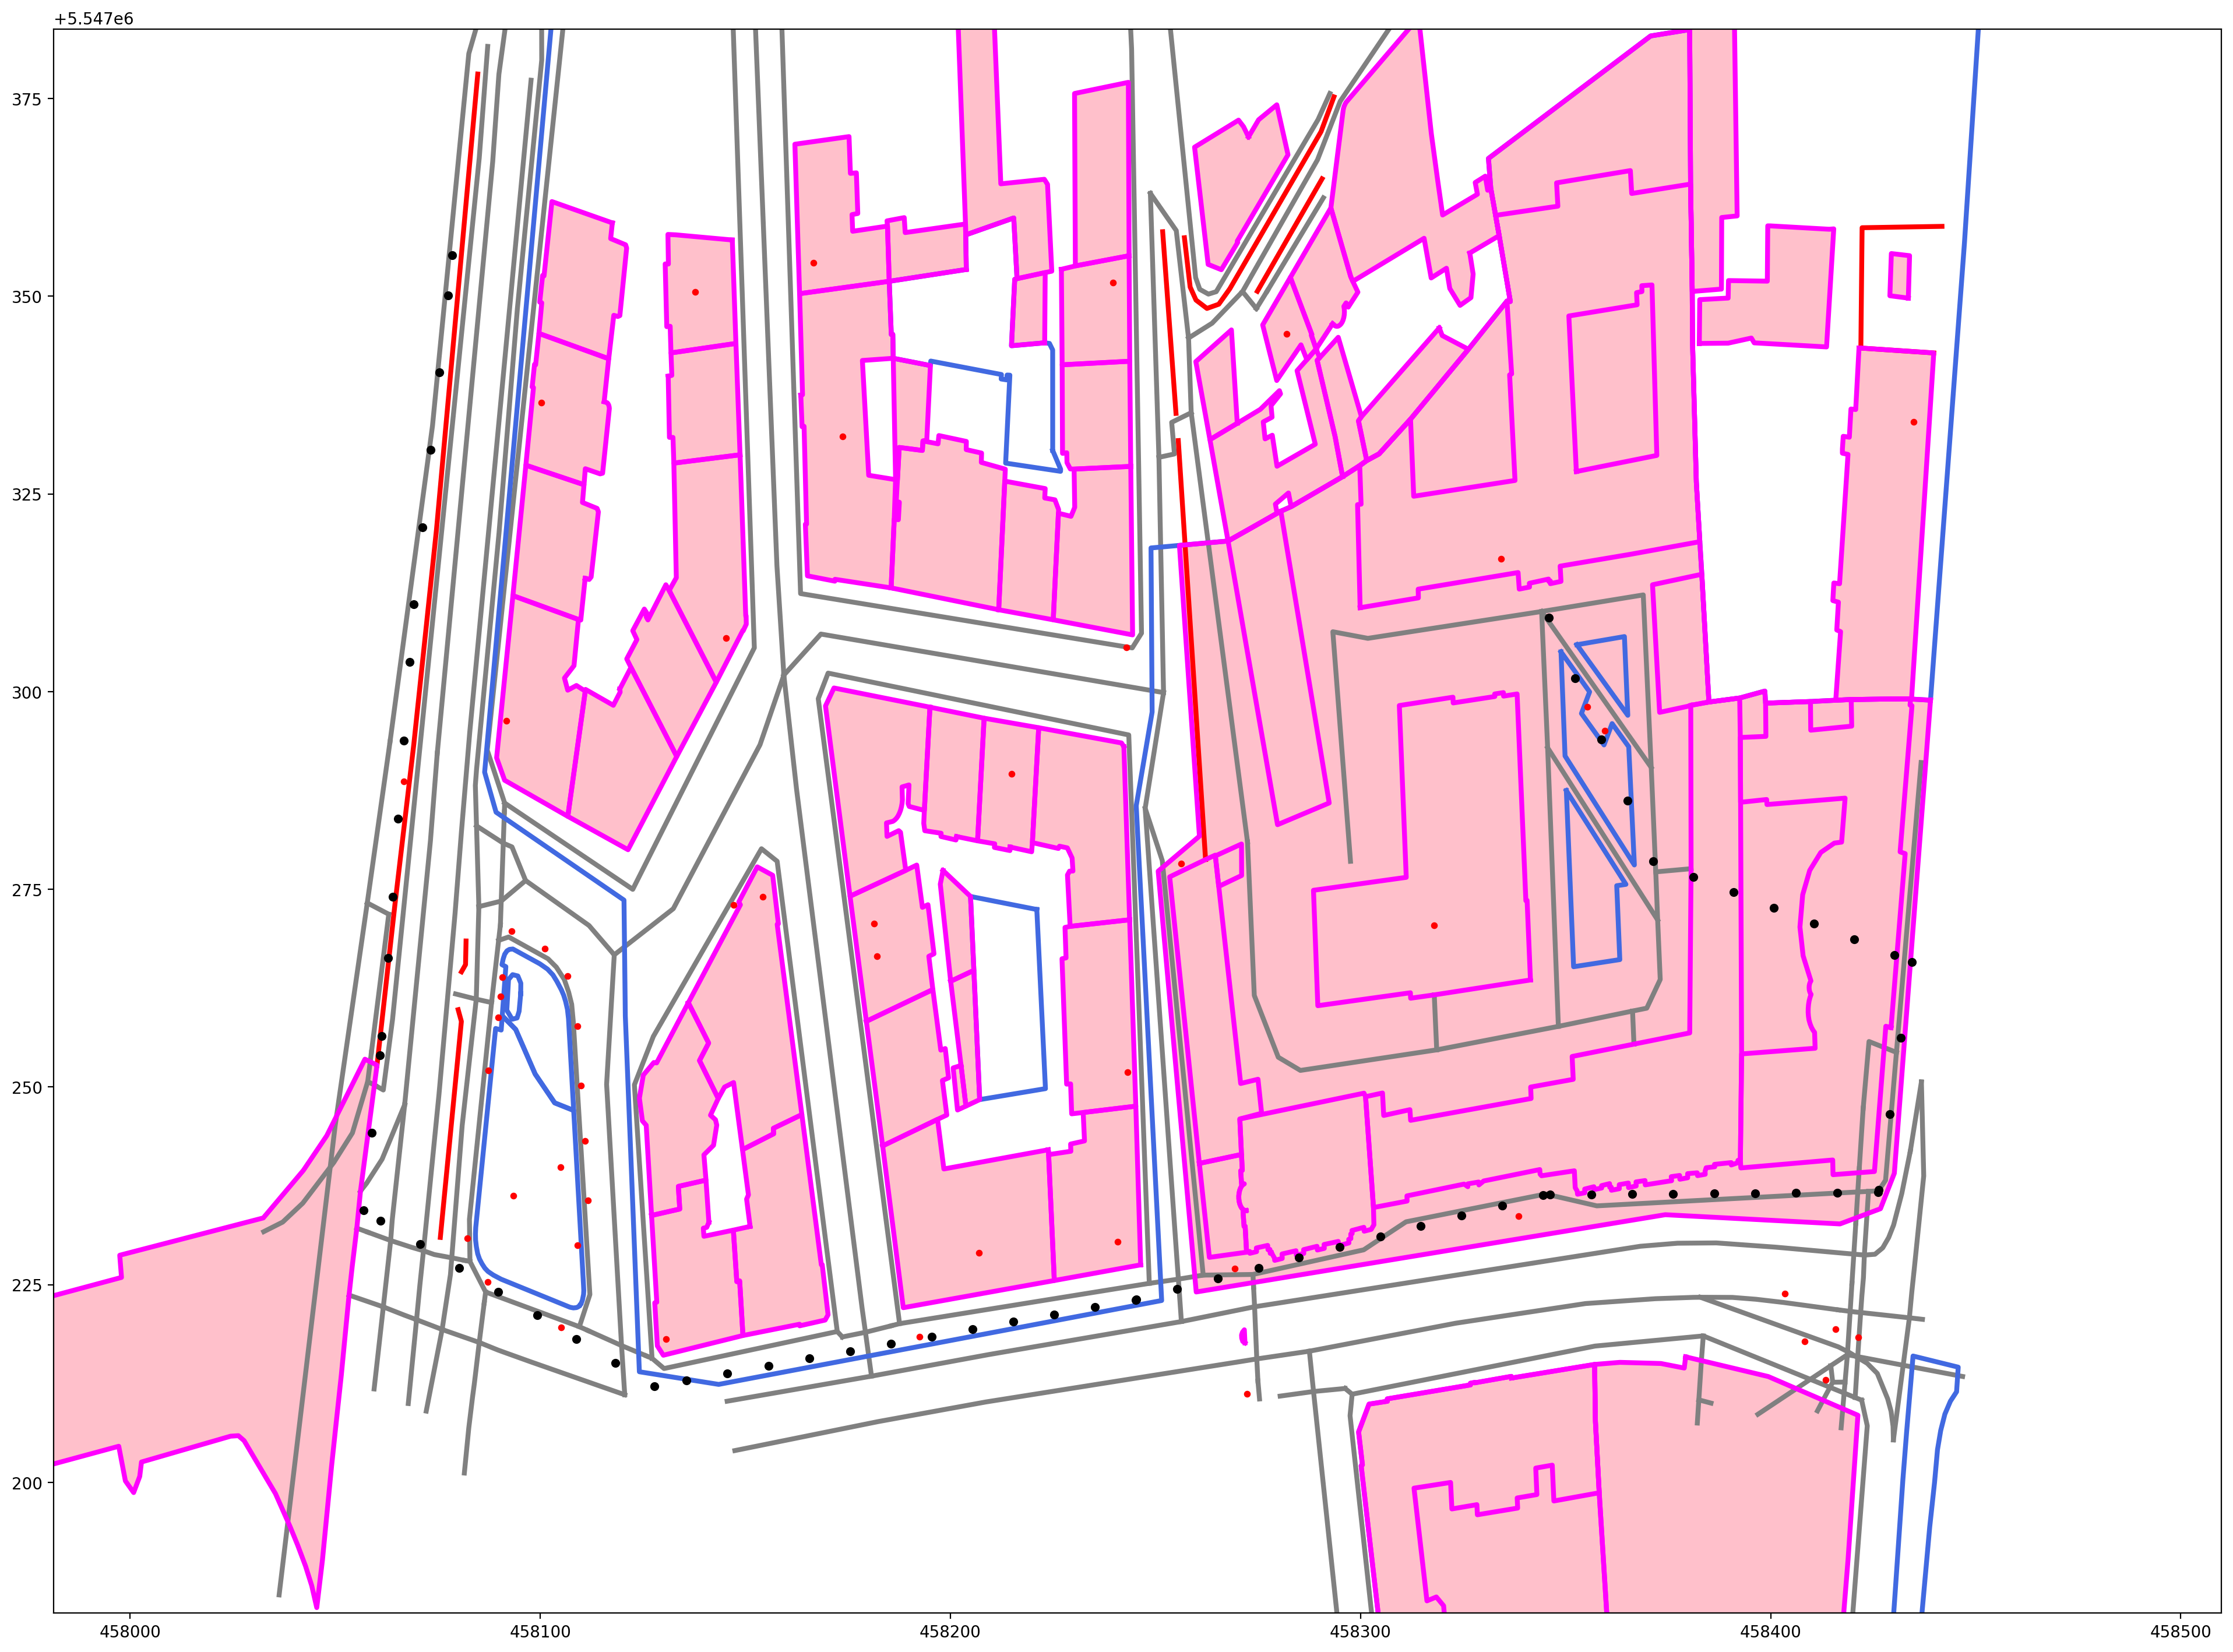

In [8]:
path_analysis.way_query = way_query
path_analysis.osm_ways_data = osm_ways_data

path_analysis.rel_query = rel_query
path_analysis.osm_rels_data = osm_rels_data

path_analysis.node_query = node_query
path_analysis.osm_nodes_data = osm_nodes_data

path_analysis.run()
path_analysis.write_to_file('path_analysis.txt')
path_analysis.plot()